# Example of GAN network on the MNIST (hand digit) dataset
<img src="https://miro.medium.com/v2/resize:fit:1400/1*uTFUp2PzqfVu0WMOE-hilA.png" alt="GAN Architecture" />

Imports

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from keras.models import Sequential, Model
try:
    from keras.optimizers.legacy import Adam
except ImportError:
    from keras.optimizers import Adam
from keras.utils import plot_model, set_random_seed
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

Load dataset and define some inputs

In [2]:
(i2, l1), (i1, l2) = mnist.load_data() # load dataset
images = np.concatenate((i1, i2)) # combine training and testing images so we have more data
labels = np.concatenate((l1, l2)) # combine training and testing labels so we have more data
img_shape = (*images.shape[1:], 1) # image shape with single channel (28x28x1)
noise_length = 128 # length of the latent vector (noise vector)
optimizer = Adam(0.0002, 0.5) # defining the optimizer
set_random_seed(1000) # Sets all random seeds (Python, NumPy, and backend framework, e.g. TF).

The generator network: Given input of noise (latent) vector, the Generator produces an image.

Model: "Generator_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               33024     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                 

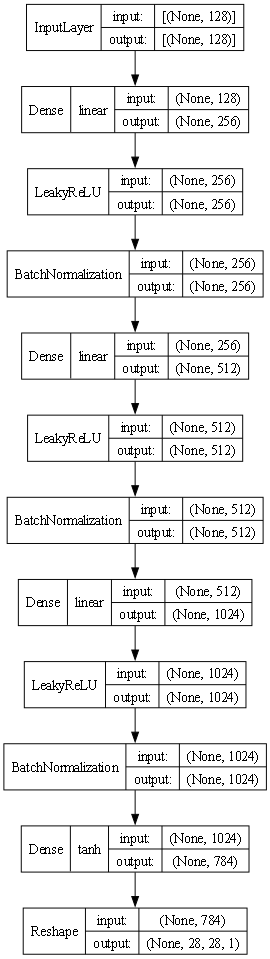

In [3]:
def build_generator():
    noise_shape = (noise_length,) 
    model = Sequential(name="Generator_Network")
    model.add(Input(shape=noise_shape))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
generator.summary(expand_nested=True)
plot_model(generator, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)

The discriminator network: Given an input image, the Discriminator outputs the likelihood of the image being real.

Model: "Discriminator_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,5

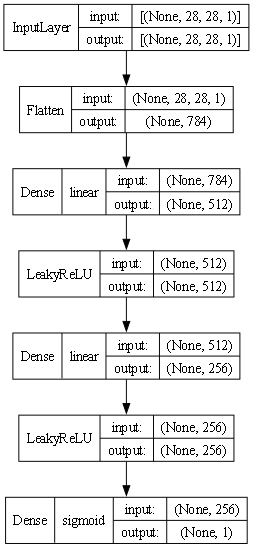

In [4]:
def build_discriminator():
    model = Sequential(name="Discriminator_Network")
    model.add(Input(shape=img_shape))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model
    
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator.summary(expand_nested=True)
plot_model(discriminator, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)

-------------------------------------------------------------------
The ultimate goal here is for the Generator to fool the Discriminator.  
The GAN model  (stacked generator and discriminator) takes
noise as input => generates images => determines validity

Model: "GAN_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 Generator_Network (Sequenti  (None, 28, 28, 1)        1500688   
 al)                                                             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dense (Dense)             (None, 256)               33024     |
|                                                               |
| leaky_re_lu (LeakyReLU)   (None, 256)               0         |
|                                                               |
| batch_normalization (BatchN  (None, 256)            1024      |
| ormalization)                                                 |
|                                                               |
| dense_1 (Dense)           (None, 512)               1

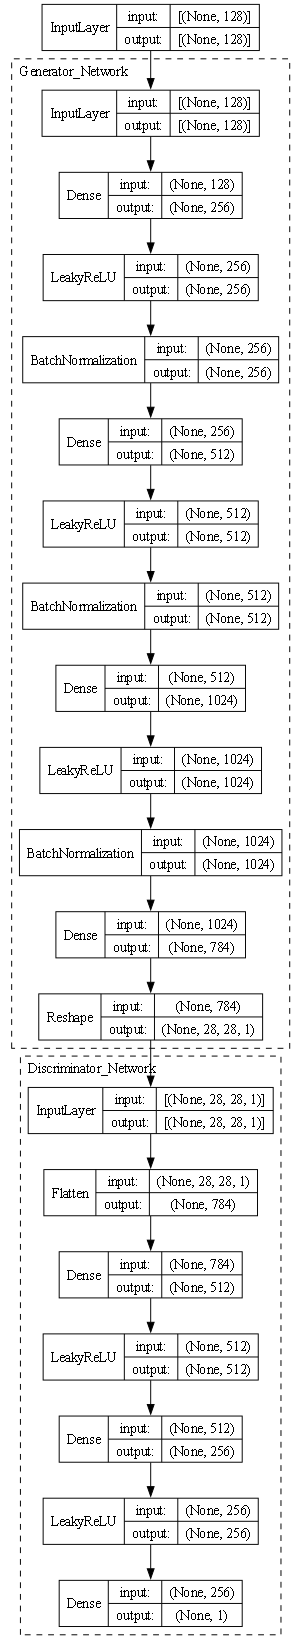

In [5]:
def build_gan():
    z = Input(shape=(noise_length,))   # Our random input to the generator
    img = generator(z)
    # While generator training we do not want discriminator weights to be trained. 
    discriminator.trainable = False  
    valid = discriminator(img)  #Validity check on the generated image
    return Model(z, valid, name="GAN_Network")
    
gan = build_gan()
gan.compile(loss='binary_crossentropy', optimizer=optimizer)
gan.summary(expand_nested=True)
plot_model(gan, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)

In order to train the GAN network we have to let the generator and the discriminator to compete with each other.

  0%|          | 0/2001 [00:00<?, ?it/s]

0 [D loss: 0.576938, D acc.: 84.38%] [G loss: 0.648043]


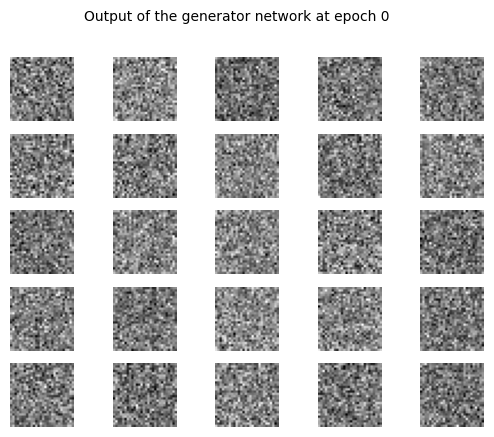

400 [D loss: 0.700730, D acc.: 37.50%] [G loss: 0.681328]


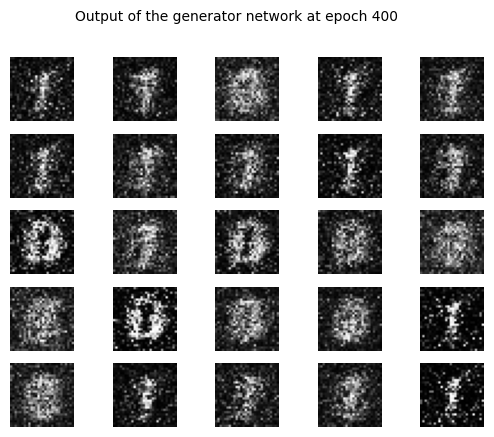

800 [D loss: 0.683574, D acc.: 56.25%] [G loss: 0.780780]


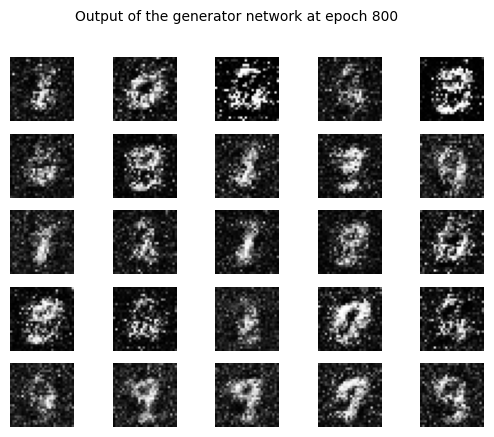

1200 [D loss: 0.605728, D acc.: 65.62%] [G loss: 0.790327]


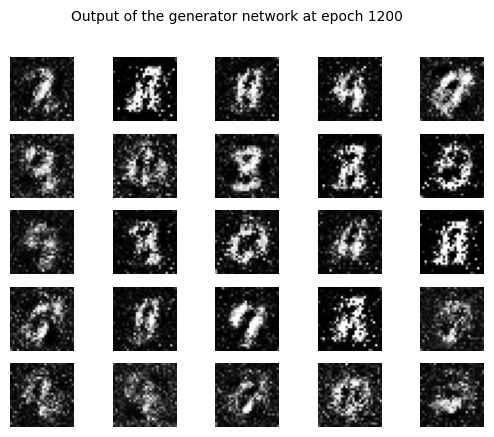

1600 [D loss: 0.569369, D acc.: 65.62%] [G loss: 0.841754]


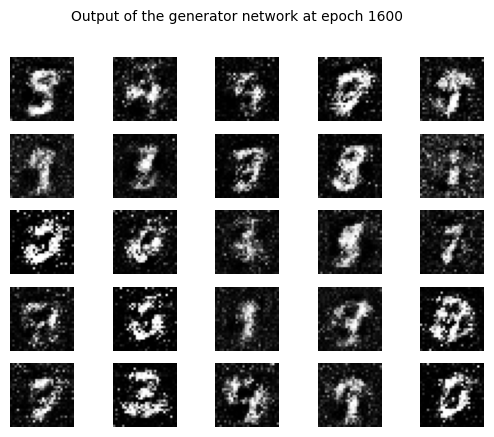

2000 [D loss: 0.547906, D acc.: 62.50%] [G loss: 0.943411]


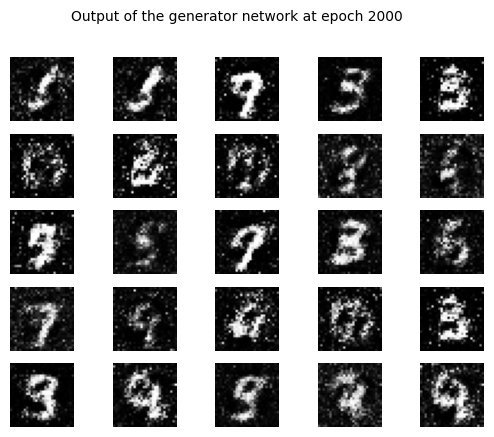

In [8]:
def train(epochs, batch_size=128, save_interval=50):
    # Convert to float and Rescale -1 to 1
    X_train = (images.astype(np.float32) - 127.5) / 127.5

    # Add channels dimension.
    if X_train.ndim<4:
        X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)

    # We then loop through a number of epochs to train our Discriminator by first selecting
    # a random batch of images from our true dataset, generating a set of images from our
    # Generator, feeding both set of images into our Discriminator, and finally setting the
    # loss parameters for both the real and fake images, as well as the GAN loss. 
    
    for epoch in tqdm(range(epochs)):
        # Train Discriminator
        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, noise_length))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise, verbose=0)

        # Train the discriminator on real and fake images, separately
        # Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        
        # take average loss from real and fake images. 
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

        # And within the same loop we train our Generator, by setting the input noise and
        # ultimately training the Generator to have the Discriminator label its samples as valid
        # by specifying the gradient loss.
        
        # Train Generator
        # Create noise vectors as input for generator. 
        # Create as many noise vectors as defined by the batch size.
        # Based on normal distribution. Output will be of size (batch size, noise_length)
        noise = np.random.normal(0, 1, (batch_size, noise_length)) 

        # The generator wants the discriminator to label the generated samples as valid (ones)
        # This is where the genrator is trying to trick discriminator into believing
        # the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) # Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        # job of folling the discriminator then the output would be 1 (true)
        g_loss = gan.train_on_batch(noise, valid_y)

        
        
        if epoch % save_interval == 0:
            print ("%d [D loss: %f, D acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            plot_imgs(epoch)


def plot_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_length))
    gen_imgs = generator.predict(noise, verbose=0)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, :], cmap="gray")
            axs[i,j].axis('off')
            cnt += 1
    fig.suptitle('Output of the generator network at epoch %d ' % epoch, fontsize=10)
    # fig.savefig("images/mnist_%d.png" % epoch)
    plt.show()


train(epochs=2001, batch_size=32, save_interval=400)
# generator.save('generator_model.h5') 